In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pyproj
import geopandas as gpd
from rasterio import features
from rasterio.warp import transform_bounds
import scipy.ndimage as nd
from orinoco import filter_binary_array_by_min_size
from tqdm import tqdm
import scipy.ndimage as nd

# Water Mask

In [2]:
tiles = ['NH15', 'NH16', 'NR08']

In [3]:
!ls grwl_data/masks

NH15.tif         NH16.tif         NR08.tif
NH15.tif.aux.xml NH16.tif.aux.xml NR08.tif.aux.xml


In [4]:
data_path = Path('grwl_data')

out_path = Path('out')
out_path.mkdir(exist_ok=True)

out_water_masks = Path('out/water_masks')
out_water_masks.mkdir(exist_ok=True, parents=True)

out_ocean_masks = Path('out/ocean_masks')
out_ocean_masks.mkdir(exist_ok=True, parents=True)

In [5]:
def open_one_water_mask(tile_name):
    with rasterio.open(data_path/f'masks/{tile_name}.tif') as ds:
        water_mask = ds.read(1).astype(bool).astype(int)
        profile = ds.profile
    return water_mask, profile

In [6]:
X, profile = open_one_water_mask(tiles[0])

In [7]:
sy = np.s_[6000:7000]
sx = np.s_[7400:7800]

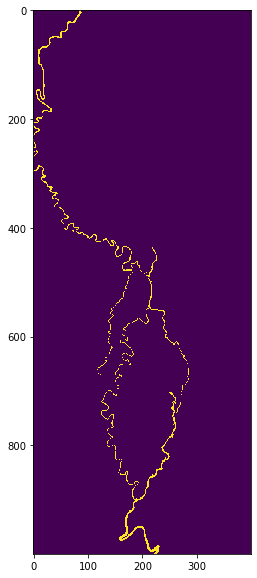

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(X[sy, sx])

In [9]:
X2 = nd.morphology.binary_dilation(X.astype(int), 
                                        iterations=1,
                                        border_value=0,
                                       structure =np.ones((3, 3)))
X3 = nd.morphology.binary_erosion(X2.astype(int), 
                                        iterations=1,
                                        border_value=0,
                                       structure =None)

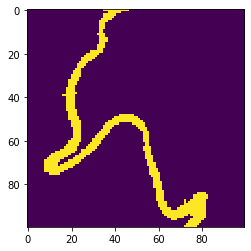

In [10]:
plt.imshow(X[sy, sx][900:, 150:250])

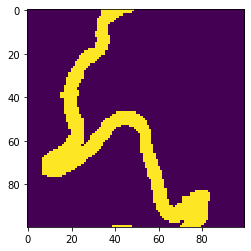

In [11]:
plt.imshow(X2[sy, sx][900:, 150:250])

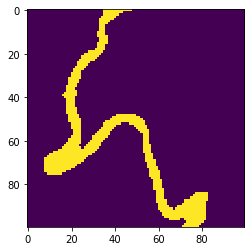

In [12]:
plt.imshow(X3[sy, sx][900:, 150:250])

In [13]:
def write_one_water_mask(tile_name):
    mask, profile = open_one_water_mask(tile_name)
    tile_dir = out_path/f'{tile_name}'
    tile_dir.mkdir(exist_ok=True, parents=True)
    mask = nd.morphology.binary_dilation(mask.astype(np.uint8), 
                                         iterations=1,
                                         border_value=0,
                                         )
    #mask = nd.morphology.binary_erosion(mask.astype(np.uint8), 
    #                                    iterations=1,
    #                                    border_value=0,
    #                                    structure =None)
    with rasterio.open(tile_dir/'water_mask.tif', 'w', **profile) as ds:
        ds.write(mask.astype('uint8'), 1)

In [14]:
list(map(write_one_water_mask, tqdm(tiles)))

100%|██████████| 3/3 [00:16<00:00,  5.61s/it]


[None, None, None]

# Initialization Mask

We use this hydropolys [dataset](https://apps.gis.ucla.edu/geodata/dataset/world_water_bodies/resource/a6b40af0-84cb-40ce-b1c5-b024527a6943). Update the path accordingly.

In [15]:
water_body_shapefile = '/Volumes/BigData/river_data/hydropolys'

In [16]:
def translate_one(geometry, profile):
    shapes = [(geometry, 1)]
    out_arr = np.zeros((profile['height'], profile['width']))
    burned = features.rasterize(shapes=shapes,
                                out=out_arr,
                                transform=profile['transform'],
                                all_touched=True)
    return burned

In [17]:
def get_ocean_mask(tile_name):
    with rasterio.open(data_path/f'masks/{tile_name}.tif') as ds:
        bounds = ds.bounds
        crs = str(ds.crs).lower()
        profile = ds.profile
    bounds_4326 = transform_bounds(crs, 'epsg:4326', *bounds)
    oceanline_df = gpd.read_file(water_body_shapefile, bbox=bounds_4326).to_crs({'init':crs})
    oceanline_df = oceanline_df[oceanline_df['TYPE'] == 'Ocean or Sea'].copy()
    ocean_geometry = oceanline_df.geometry.unary_union.buffer(1e-9)
    ocean_mask = translate_one(ocean_geometry, profile)
    return ocean_mask, profile

In [18]:
mask, profile = get_ocean_mask(tiles[0])

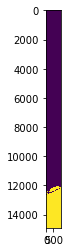

In [19]:
plt.imshow(mask[:, :1000])

In [20]:
def write_ocean_mask(tile_name):
    mask, profile = get_ocean_mask(tile_name)
    tile_dir = out_path/f'{tile_name}'
    tile_dir.mkdir(exist_ok=True, parents=True)
    with rasterio.open(tile_dir/'ocean_mask.tif', 'w', **profile) as ds:
        ds.write(mask.astype('uint8'), 1)

In [21]:
list(map(write_ocean_mask, tqdm(tiles)))

100%|██████████| 3/3 [00:21<00:00,  7.15s/it]


[None, None, None]